*Joana Leite* </br>
March 2024

https://towardsdatascience.com/8-visualizations-with-python-to-handle-multiple-time-series-data-19b5b2e66dd0

# 0. Preamble

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.offsetbox import AnchoredText
import plotly.express as px

# 1. Import data

In [2]:
df = pd.read_csv('all_bike_counts.csv', parse_dates=['detected'], dtype='int32')
df = df.set_index('detected')
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 22632 entries, 2021-08-01 00:00:00 to 2024-02-29 23:00:00
Data columns (total 62 columns):
 #   Column        Non-Null Count  Dtype
---  ------        --------------  -----
 0   direction_2   22632 non-null  int32
 1   count_2       22632 non-null  int32
 2   direction_3   22632 non-null  int32
 3   count_3       22632 non-null  int32
 4   direction_4   22632 non-null  int32
 5   count_4       22632 non-null  int32
 6   direction_5   22632 non-null  int32
 7   count_5       22632 non-null  int32
 8   direction_6   22632 non-null  int32
 9   count_6       22632 non-null  int32
 10  direction_7   22632 non-null  int32
 11  count_7       22632 non-null  int32
 12  direction_8   22632 non-null  int32
 13  count_8       22632 non-null  int32
 14  direction_9   22632 non-null  int32
 15  count_9       22632 non-null  int32
 16  direction_10  22632 non-null  int32
 17  count_10      22632 non-null  int32
 18  direction_11  22632 non-null  i

In [3]:
df_loc = pd.read_csv('all_counter_locations.csv')
df_loc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31 entries, 0 to 30
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   locationId         31 non-null     int64  
 1   tenantIdentifier   31 non-null     object 
 2   name               31 non-null     object 
 3   cp7                31 non-null     object 
 4   freguesia          31 non-null     object 
 5   directionPositive  0 non-null      float64
 6   directionNegative  0 non-null      float64
 7   latitude           31 non-null     float64
 8   longitude          31 non-null     float64
dtypes: float64(4), int64(1), object(4)
memory usage: 2.3+ KB


# 2. Visualize all locations

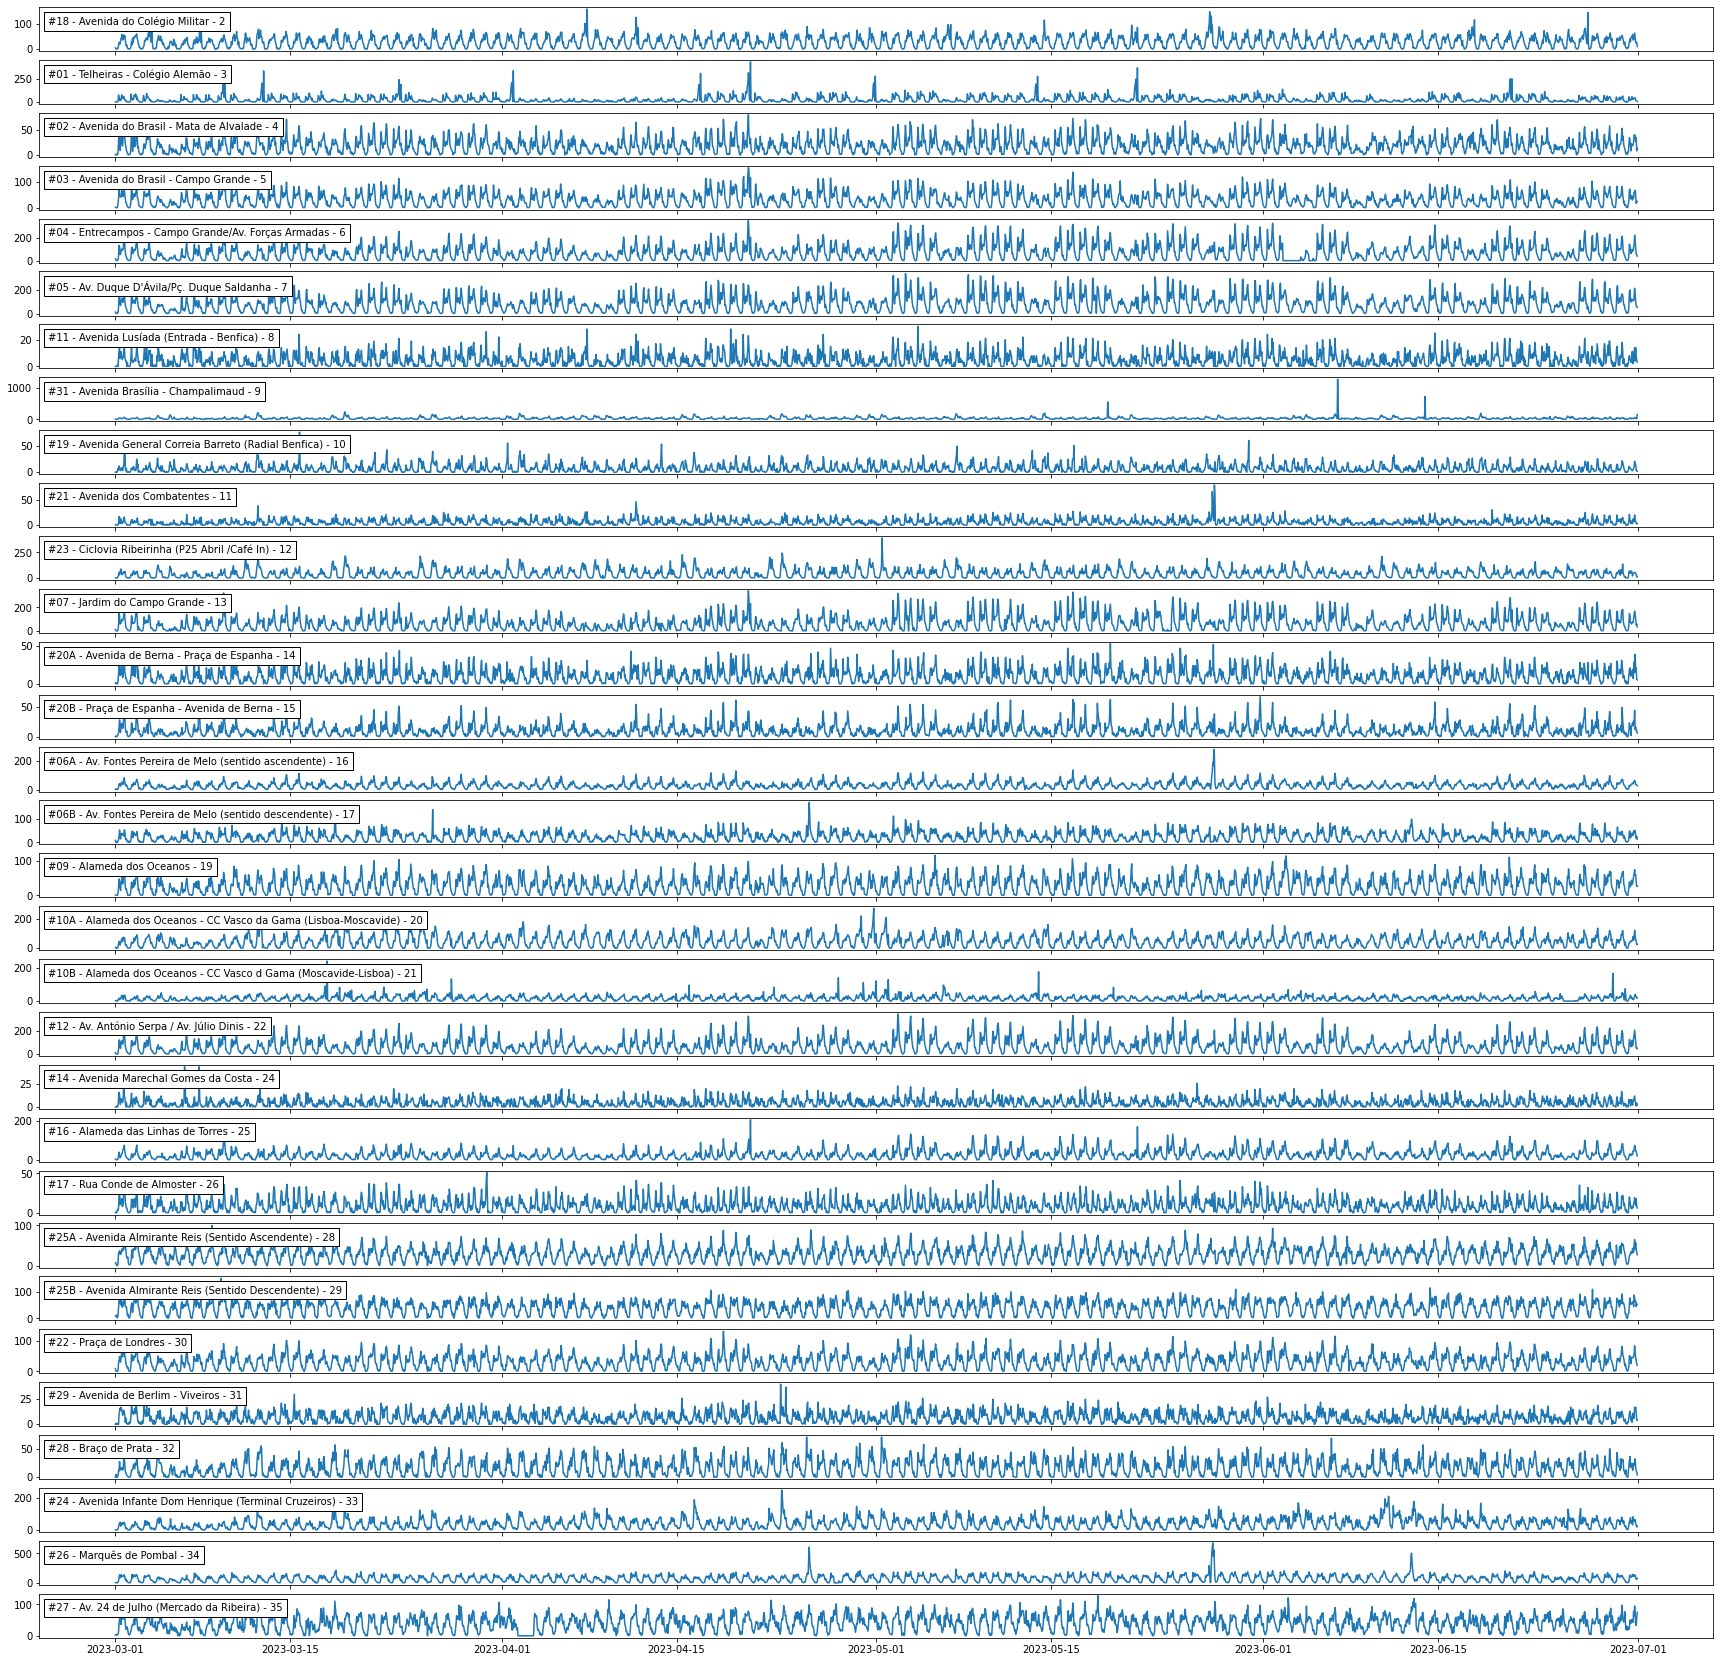

In [4]:
locationId_all = df_loc.locationId.to_list()
locationId_remove = []
locationId_keep = [elem for elem in locationId_all if elem not in locationId_remove]

fig, ax = plt.subplots(len(locationId_keep), 1, figsize=(30,30), sharex=True)
for i,location in enumerate(locationId_keep):
    ax[i].plot(df.query('"2023-03"<index<"2023-07"').loc[:,f'count_{location}'])
    counter_name = AnchoredText(df_loc.query('locationId == @location').name.values[0] + ' - ' + str(location), loc="upper left")
    ax[i].add_artist(counter_name)
plt.show()

In [5]:
# Aqui era um gráfico do plotly. Por algum motivo já não está a dar.
fig = px.line(df, x=df.index, y='count_6')
fig.update_xaxes(rangeslider_visible=True)
fig.show()

c:\Users\User\envs\generic_env\lib\site-packages\_plotly_utils\basevalidators.py:107: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  v = v.dt.to_pydatetime()


In [6]:
df_query = df.filter(['count_6']).query('"2021-10-30" < index < "2021-10-31"')

In [7]:
fig = px.line(df, x=df.index, y='count_31')
fig.update_xaxes(rangeslider_visible=True)
fig.show()

In [8]:
# Jornadas Mundiais da Juventude
df_query = df.filter(['count_31']).query('"2023-08-05" < index < "2023-08-07"')

# 3. Seasonal visualization

In [9]:
def prep_df_fig(df_all, start_date, end_date, column):
    df_raw = df_all.query('@start_date <= index < @end_date').filter([column])
    df_raw = df_raw.assign(
        woy = df_raw.index.isocalendar().week,
        dow = df_raw.index.dayofweek,
        hod = df_raw.index.hour
        ).reset_index()
    df_raw = df_raw.assign(idx = (df_raw.dow)*24 + df_raw.hod)
    df_fig = df_raw.pivot(index='idx', columns='woy', values=column)
    df_fig = df_fig.assign(mean_hour = df_fig.agg('mean', axis=1))
    return df_fig

def prep_ticks_fig(hour_list):
    hour_list_aux = [0] + hour_list
    tick_list = []
    tick_label_list = []
    days = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
    for i,d in zip(np.arange(0, 167, 24),days):
        tick_list_aux = hour_list_aux + i
        tick_list = tick_list + tick_list_aux.tolist()
        tick_label_list_aux = [d] + [str(h)+':00' for h in hour_list]
        tick_label_list = tick_label_list + tick_label_list_aux
    return tick_list, tick_label_list

def plot_weekly_count(df_all, df_all_loc, start_date, end_date, loc, hour_list):
    location_name = df_all_loc.query('locationId == @loc').name.values[0]
    column = 'count_' + str(location)
    df_plot = prep_df_fig(df_all, start_date, end_date, column)
    tick_list, tick_label_list = prep_ticks_fig(hour_list)
    fig,ax = plt.subplots(1, 1, figsize=(26,4))
    for i in tick_list:
        if i in np.arange(0, 167, 24):
            ax.axvline(i, color='cadetblue', linestyle='dashed', linewidth=1.5)
        else:
            ax.axvline(i, color='aliceblue', linestyle='dashed')
    for i in list(range(len(df_plot.columns[:-1]))):
        ax.plot(df_plot.iloc[:,i], color='gray', alpha=0.15, linewidth=1.5)
    ax.plot(df_plot.iloc[:,-1], color='indianred', alpha=0.8, linewidth=1.5, label='mean')
    plt.xticks(ticks=tick_list, labels=tick_label_list)
    ax.set_title(f'Weekly count at {location_name}   ({start_date} - {end_date})')
    ax.legend()
    plt.show()

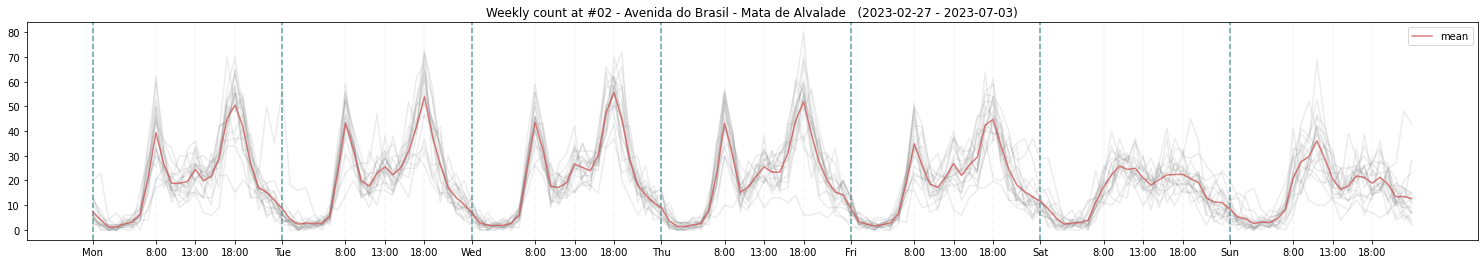

In [43]:
location = 4
s_date = "2023-02-27"
e_date = "2023-07-03"
ticks_hours = [8, 13, 18]

plot_weekly_count(df, df_loc, s_date, e_date, location, ticks_hours)

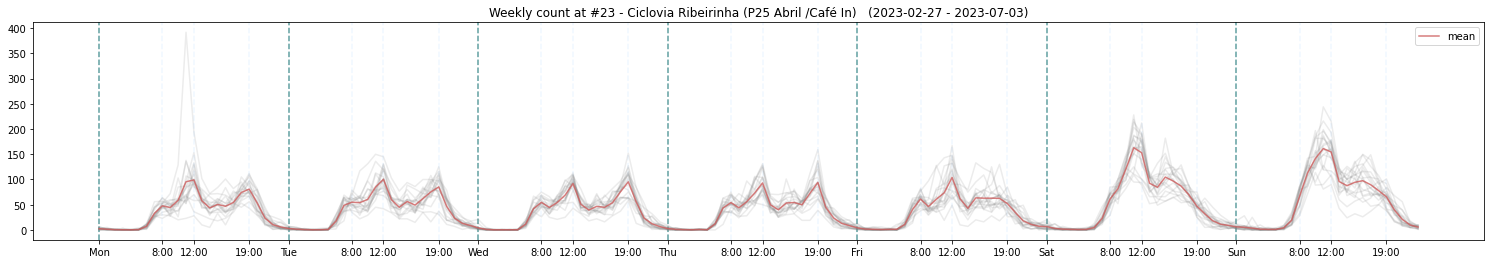

In [44]:
location = 12
s_date = "2023-02-27"
e_date = "2023-07-03"
ticks_hours = [8, 12, 19]

plot_weekly_count(df, df_loc, s_date, e_date, location, ticks_hours)

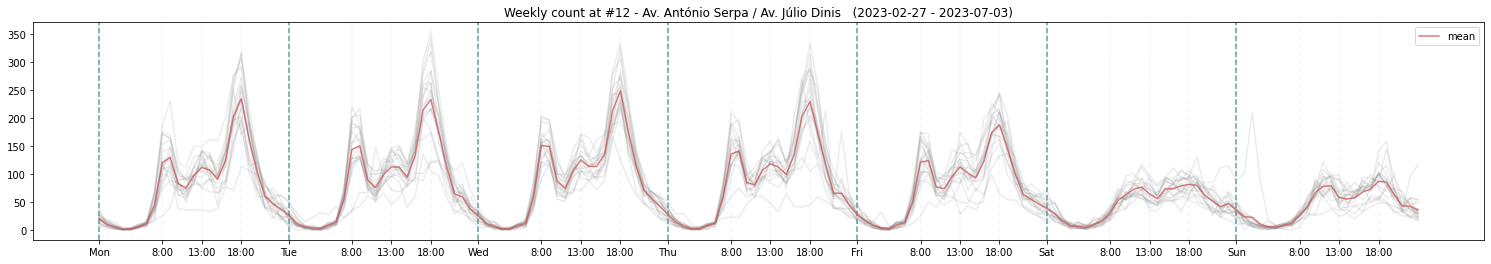

In [45]:
location = 22
s_date = "2023-02-27"
e_date = "2023-07-03"
ticks_hours = [8, 13, 18]

plot_weekly_count(df, df_loc, s_date, e_date, location, ticks_hours)